In [2]:
%matplotlib inline
# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
import numpy.random as rd
import tensorflow as tf

from lsnn.guillaume_toolbox.matplotlib_extension import strip_right_top_axis, raster_plot, hide_bottom_axis

from matplotlib import collections as mc, patches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import pickle
import json
import os

In [3]:
# Covert data units to points
def height_from_data_units(height, axis, reference='y', value_range=None):
    fig = axis.get_figure()
    if reference == 'x':
        length = fig.bbox_inches.width * axis.get_position().width
        if value_range is None:
            value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        length = fig.bbox_inches.height * axis.get_position().height
        if value_range is None:
            value_range = np.diff(axis.get_ylim())
    # Convert length to points
    length *= 72
    # Scale height to value range
    ms = height * (length / value_range)
    return ms

def plot_spikes(ax, spikes, linewidth=0.5, max_spike=None, color='black'):
    # import matplotlib.ticker as ticker
    n_neurons = spikes.shape[0]
    neurons = np.arange(n_neurons) + 1
    sps = spikes * (neurons.reshape(len(spikes), 1))
    sps[sps == 0.] = -10
    sps -= 1
    marker_size = height_from_data_units(0.7, ax, value_range=n_neurons)
    for neuron in range(n_neurons):
        ax.plot(range(spikes.shape[1]), sps[neuron, :], marker='|', linestyle='none', color=color,
                markersize=marker_size, markeredgewidth=linewidth)
    ax.set(ylim=(-0.5, n_neurons))
    ax.yaxis.set_major_locator(ticker.FixedLocator([0, n_neurons]))


In [4]:
data_path='/home/dsalaj/Desktop/560_figs/2019_12_05_17_13_18_FastALIF_seqlen10_seqdelay4_in88_R0_A500_lr0.01_tauchar200_comment560_ExtSR_FastLONG2_GPU_1/'
custom_plot=False
spikesonly=True
restonly=False

In [5]:
flags_dict = json.load(open(os.path.join(data_path, 'flags.json')))
from types import SimpleNamespace
FLAGS = SimpleNamespace(**flags_dict)

plot_data = 'plot_custom_trajectory_data.pickle' if custom_plot else 'plot_trajectory_data.pickle'
data = pickle.load(open(os.path.join(data_path, plot_data), 'rb'))

raw_input = data['input_spikes']  # also for analog input the key is 'input_spikes'
# print(FLAGS)
# print(raw_input.shape)  # batch, time, channels (128, 1000, 60)
shp = raw_input.shape
ch_in = np.mean(np.reshape(raw_input, (shp[0], -1, FLAGS.tau_char, shp[2])), axis=2)  # avg per char step

shp = ch_in.shape
ch_in = np.mean(np.reshape(ch_in, (shp[0], shp[1], -1, FLAGS.n_per_channel)), axis=3)  # avg per channel
ch_in = ch_in > 0.0  # convert to binary

n_group = FLAGS.n_charac  # size of a group in input channels. groups: store-recall, input, inv-input
assert ch_in.shape[2] == 2 * n_group + 2 * 2, \
    "ch_in.shape[2]" + str(ch_in.shape[2]) + " does not contain 2 groups of " + str(n_group) + " + 2"

store = np.mean(ch_in[:, :, 0:2], axis=2)[..., np.newaxis]  # first half of first group
recall = np.mean(ch_in[:, :, 2:4], axis=2)[..., np.newaxis]  # second half of first group
norm_input = ch_in[:, :, 4:4 + n_group]

In [6]:
store_idxs = np.nonzero(store)  # list of batch idxs, list of time idxs
recall_idxs = np.nonzero(recall)  # list of batch idxs, list of time idxs
delays = [r - s for s, r in zip(store_idxs[1], recall_idxs[1])]
# long_delay_batch = np.argmax(delays)
long_delay_batch = np.argpartition(delays, 4)[-1]
# print("argmax", long_delay_batch)
# print("np.argpartition(delays, -4)[-4:]", np.argpartition(delays, -4)[-4:])
# print("np.argsort(delays)[-4:]", np.argsort(delays)[-4:])

start_time = datetime.datetime.now()
filename = os.path.join(data_path, 'NEW_figure_test' + str(long_delay_batch) + '_' + start_time.strftime("%H%M"))

In [7]:
# plt.ion()
# fig, ax_list = plt.subplots(nrows=5, figsize=(6, 7.3), gridspec_kw={'wspace': 0, 'hspace': 0.2})
fig = plt.figure(figsize=(7.3, 8), tight_layout=True)
gs = gridspec.GridSpec(13, 10, wspace=0.45, hspace=0.2)
plt.subplots_adjust(left=0.13, right=0.96, top=0.99, bottom=0.06)

<Figure size 525.6x576 with 0 Axes>

In [9]:
plot_result_values = data
batch = long_delay_batch

ylabel_x = -0.11
ylabel_y = 0.5
fs = 10
plt.rcParams.update({'font.size': fs})

top_margin = 0.08
left_margin = -0.085
spikewidth = 0.5

# PLOT INPUT PATTERNS
for pi in range(norm_input.shape[1]):  # this should be 10
    ax = fig.add_subplot(gs[:2, pi])
    pattern_flat = norm_input[batch, pi]
    pattern = np.reshape(pattern_flat, (5, 4))
    ax.imshow(pattern, cmap='binary')
    if pi in np.nonzero(store[batch])[0]:
        for spine in ax.spines.values():
            spine.set_edgecolor('orange')
            spine.set_linewidth(4)
    ax.set_xticks([])
    ax.set_yticks([])

# PLOT STORE-RECALL SIGNAL SPIKES
max_spike = 20000
# ax = fig.add_subplot(gs[1, :])
# ax.clear()
# strip_right_top_axis(ax)
n_neuron_per_channel = FLAGS.n_in // (FLAGS.n_charac * 2 + 2 * 2)
assert n_neuron_per_channel == FLAGS.n_per_channel
sr_num_channels = 2 * 2
sr_num_neurons = sr_num_channels * n_neuron_per_channel
sr_spikes = plot_result_values['input_spikes'][batch, :, :sr_num_neurons]


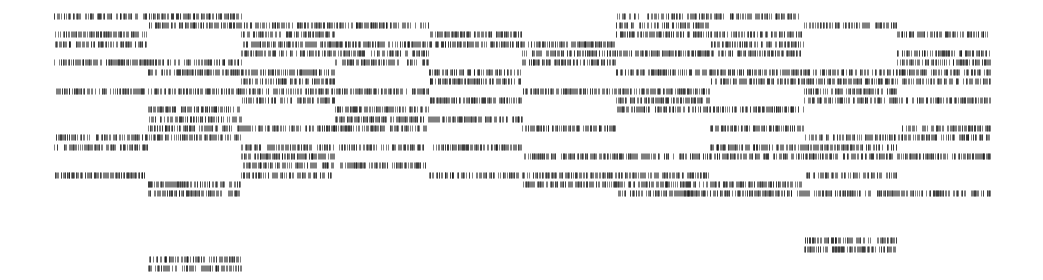

In [87]:
# PLOT INPUT SPIKES

# fig = plt.figure(figsize=(7.3, 3), tight_layout=True)
fig = plt.figure(figsize=(14.6, 4), tight_layout=True)
plt.subplots_adjust(left=0.13, right=0.96, top=0.99, bottom=0.06)

data = plot_result_values['input_spikes']
d_name = 'input'
ax = fig.add_subplot()
ax.clear()
strip_right_top_axis(ax)
# ax.grid(color='black', alpha=0.15, linewidth=0.4)
hide_bottom_axis(ax)
ax.set_yticklabels([])
if spikesonly:
    ax.spines['left'].set_visible(False)
    ax.set_xticklabels([])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

data = data[batch]
# data = data[:, sr_num_neurons::FLAGS.n_per_channel]  # subsample to one neuron per channel
data = data[:, sr_num_neurons:sr_num_neurons + FLAGS.n_charac*FLAGS.n_per_channel]
# max_y_tick_label = str(data.shape[-1])
# data = np.mean(data.reshape(data.shape[0], -1, n_neuron_per_channel), axis=2)
# cax = ax.imshow(data.T, origin='lower', aspect='auto', cmap='viridis', interpolation='none')
input_spikes = np.hstack((sr_spikes, np.zeros_like(sr_spikes), data))
if not restonly:
    plot_spikes(ax, input_spikes[:, ::FLAGS.n_per_channel].T, linewidth=spikewidth, max_spike=max_spike)
presentation_steps = np.arange(input_spikes.shape[0])
ax.set_xticks([0, presentation_steps[-1] + 1])
ax.set_ylabel(d_name, fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
# ax.set_yticklabels(['1', max_y_tick_label])
if spikesonly:
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig(filename + '_SPIKES_INPUT.png', bbox_inches=extent, dpi=1000)


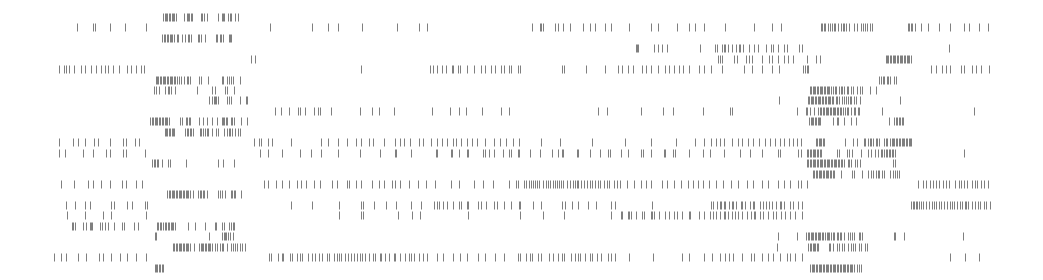

In [94]:
# PLOT ALIF SPIKES
fig = plt.figure(figsize=(14.6, 4), tight_layout=True)
plt.subplots_adjust(left=0.13, right=0.96, top=0.99, bottom=0.06)

sub_data = plot_result_values['b_con'][batch]
thr_vars = np.var(sub_data, axis=0)
cell_with_max_var = np.argsort(thr_vars)[::-1]
# cell_choice = cell_with_max_var[::20]
# cell_choice = cell_with_max_var[150:180]
# cell_choice = cell_with_max_var[290:300]
# cell_choice = cell_with_max_var[300:350]  # saprse firing
cell_choice = cell_with_max_var[325:350]


d_name = 'ALIF'
ax = fig.add_subplot()
ax.clear()
strip_right_top_axis(ax)
# ax.grid(color='black', alpha=0.15, linewidth=0.4)
hide_bottom_axis(ax)
ax.set_yticklabels([])
if spikesonly:
    ax.spines['left'].set_visible(False)
    ax.set_xticklabels([])
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    ax.get_yaxis().set_visible(False)

data = plot_result_values['z']
data = data[batch]
data = data[:, cell_choice]

# cell_select = np.linspace(start=0, stop=data.shape[1] - 1, dtype=int)
# data = data[:, cell_select]  # select a maximum of n_max_neuron_per_raster neurons to plot
if not restonly:
    plot_spikes(ax, data.T, linewidth=spikewidth, max_spike=max_spike)

ax.set_ylabel(d_name, fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
# ax.set_yticklabels(['1', str(data.shape[-1])])
if spikesonly:
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename + '_SPIKES_ALIF.png', bbox_inches=extent, dpi=1000)


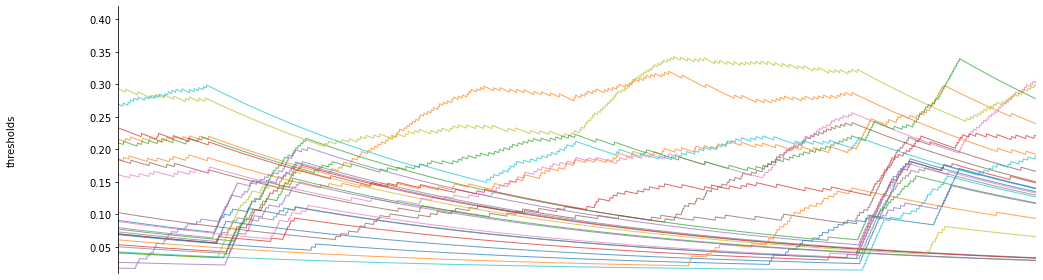

In [95]:
fig = plt.figure(figsize=(14.6, 4), tight_layout=True)
plt.subplots_adjust(left=0.13, right=0.96, top=0.99, bottom=0.06)

ax = fig.add_subplot()
ax.clear()
strip_right_top_axis(ax)
# ax.grid(color='black', alpha=0.15, linewidth=0.4)
ax.set_ylabel('thresholds', fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
presentation_steps = np.arange(sub_data.shape[0])
# ax.plot(sub_data[:, cell_with_max_var[::10]], color='r', alpha=0.4, linewidth=1)
ax.plot(sub_data[:, cell_choice], alpha=0.7, linewidth=1)
# ax.plot(sub_data[:, cell_with_max_var], alpha=0.7, linewidth=1)
ax.axis([0, presentation_steps[-1], np.min(sub_data[:, cell_with_max_var]),
         np.max(sub_data[:, cell_with_max_var])])  # [xmin, xmax, ymin, ymax]
hide_bottom_axis(ax)
fig.savefig(filename + '_THR_ALIF.svg', bbox_inches=extent)

Text(0.5, 0, 'time in s')

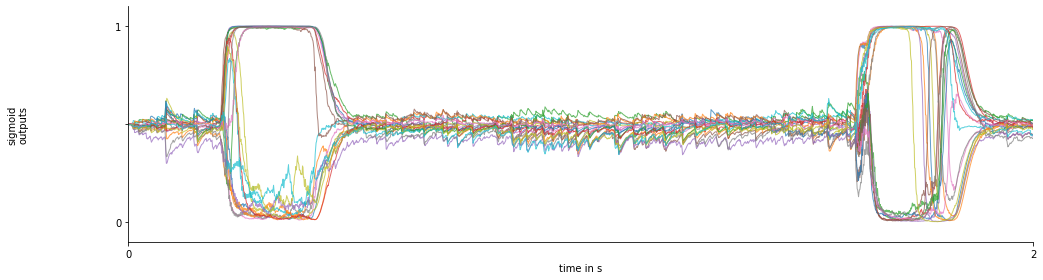

In [51]:
fig = plt.figure(figsize=(14.6, 4), tight_layout=True)
plt.subplots_adjust(left=0.13, right=0.96, top=0.99, bottom=0.06)


# plot targets
ax = fig.add_subplot()
ax.clear()
strip_right_top_axis(ax)
# plot softmax of psp-s per dt for more intuitive monitoring
# ploting only for second class since this is more intuitive to follow (first class is just a mirror)
output2 = plot_result_values['out_plot'][batch, :, :]
presentation_steps = np.arange(output2.shape[0])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0', '', '1'])
# ax.grid(color='black', alpha=0.15, linewidth=0.4)
ax.set_ylabel('sigmoid\noutputs', fontsize=fs)
ax.get_yaxis().set_label_coords(ylabel_x, ylabel_y)
ax.plot(output2, label='output', alpha=0.7, linewidth=1)
ax.axis([0, presentation_steps[-1] + 1, -0.1, 1.1])
# ax.legend(handles=[line_output2], loc='lower center', fontsize=7,
#           bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_xticks([0, presentation_steps[-1] + 1])
ax.set_xticklabels(['0', str(int((presentation_steps[-1] + 1) / 1000))])
ax.set_xlabel('time in s', fontsize=fs)

In [10]:
time_s = plot_result_values['z'].shape[1] / 1000
fr_avg = np.mean(plot_result_values['z'], axis=1).flatten()  # average over time
fr_avg = fr_avg * 1000 / time_s
print("Meadian", np.median(fr_avg))
print(f"Mean {np.mean(fr_avg):.2f} +-{np.std(fr_avg):.2f} Hz")


Meadian 15.0
Mean 13.90 +-8.76 Hz


In [11]:
plot_result_values['z'].shape

(256, 2000, 500)

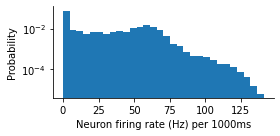

In [256]:
# Firing rate analysis
def plot_fr_hist(data, bin_size=FLAGS.tau_char):
    fig = plt.figure(figsize=(4, 2), tight_layout=True)
    plt.subplots_adjust(left=0.13, right=0.96, top=0.99, bottom=0.06)
    ax = fig.add_subplot()
    ax.clear()
    strip_right_top_axis(ax)
    # data = data[batch]
    fr_avg = data.reshape(data.shape[0], data.shape[1]//bin_size, bin_size, data.shape[2])
    fr_avg = np.sum(fr_avg, axis=2)  # num.spikes per 200ms (FLAGS.tau_char)
    to_hz_factor = 1000 / bin_size
    fr_hz = fr_avg * to_hz_factor

    x = fr_hz.flatten()
    ax.hist(x, bins=min(bins, 30), density=True, log=True)
    # plt.yscale('log')
    plt.xlabel(f'Neuron firing rate (Hz) per {bin_size}ms')
    plt.ylabel('Probability')
    return fig

fig = plot_fr_hist(plot_result_values['z'], bin_size=1000)
fig.savefig(filename + '_fr_bar.svg')

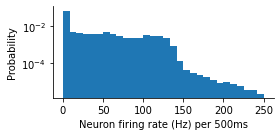

In [253]:
fig = plot_fr_hist(plot_result_values['z'], bin_size=500)

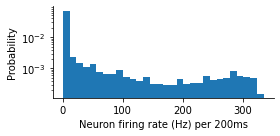

In [254]:
fig = plot_fr_hist(plot_result_values['z'], bin_size=FLAGS.tau_char)

5.3317766


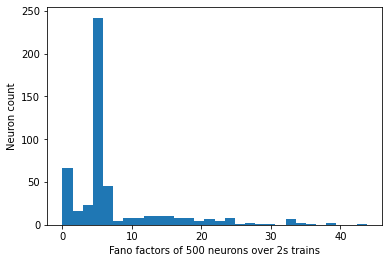

In [172]:
# Firing rate analysis
def fano_hist(data):
    # data = data[batch]  # batch, time, neuron
    spk_count = np.sum(data, axis=1)  # num.spikes per trial per neuron
    fano = np.var(spk_count, axis=0) / (np.mean(spk_count, axis=0)+1e-9)  # fano per neuron
    print(np.median(fano))
    
    plt.hist(fano, bins=min(bins, 30), density=False)
    # plt.yscale('log')
    plt.xlabel(f'Fano factors of 500 neurons over 2s trains')
    plt.ylabel('Neuron count')

fano_hist(plot_result_values['z'])
# fano_hist(np.array([[[1],[1]], [[1],[1]], [[1],[1]], [[1],[0]], ]))
# fano_hist(np.tile(plot_result_values['z'][0], (10, 1, 1)))

26.102295


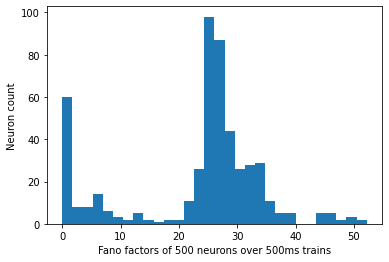

In [160]:
# Firing rate analysis
def fano_hist(data, bin_size=500):
    # data = data[batch]  # batch, time, neuron
    spk_count = data.reshape(data.shape[0], data.shape[1]//bin_size, bin_size, data.shape[2])
    spk_count = np.sum(spk_count, axis=2)  # num.spikes per bin_size
    spk_count = spk_count.reshape(-1, spk_count.shape[2])
    fano = np.var(spk_count, axis=0) / (np.mean(spk_count, axis=0)+1e-9)  # fano per neuron
    print(np.median(fano))
    
    plt.hist(fano, bins=min(bins, 30), density=False)
    # plt.yscale('log')
    plt.xlabel(f'Fano factors of 500 neurons over {bin_size}ms trains')
    plt.ylabel('Neuron count')

fano_hist(plot_result_values['z'], bin_size=500)

5.3317766
15.4 78.4


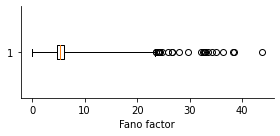

In [259]:
def fano_box(data):
    fig = plt.figure(figsize=(4, 2), tight_layout=True)
    plt.subplots_adjust(left=0.13, right=0.96, top=0.99, bottom=0.06)
    ax = fig.add_subplot()
    ax.clear()
    strip_right_top_axis(ax)

    # data = data[batch]  # batch, time, neuron
    spk_count = np.sum(data, axis=1)  # num.spikes per trial per neuron
    fano = np.var(spk_count, axis=0) / (np.mean(spk_count, axis=0)+1e-9)  # fano per neuron
    print(np.median(fano))
    q1, q3 = np.quantile(fano, (0.25, 0.75))
    w1 = q1 - 1.5*(q3-q1)
    w2 = q3 + 1.5*(q3-q1)
    
    w1 = stats.percentileofscore(fano, w1)
    w2 = stats.percentileofscore(fano, w2)
    print(w1, w2)  # figuring out the percentiles of the original whis=1.5
    
    ax.boxplot(fano, vert=False, whis=(5, 95))
    # whiskers drawn at whis percentiles
    
    # plt.yscale('log')
    # plt.xlabel(f'Fano factors of 500 neurons over 2s trains')
    plt.xlabel('Fano factor')
    return fig

fig = fano_box(plot_result_values['z'])
fig.savefig(filename + '_ff_box.svg')

5.3317766
15.4 78.4


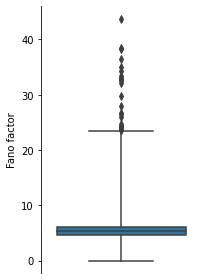

In [225]:
def fano_box(data):
    fig = plt.figure(figsize=(3, 4), tight_layout=True)
    plt.subplots_adjust(left=0.13, right=0.96, top=0.99, bottom=0.06)
    
    spk_count = np.sum(data, axis=1)  # num.spikes per trial per neuron
    fano = np.var(spk_count, axis=0) / (np.mean(spk_count, axis=0)+1e-9)  # fano per neuron
    print(np.median(fano))
    q1, q3 = np.quantile(fano, (0.25, 0.75))
    w1 = q1 - 1.5*(q3-q1)
    w2 = q3 + 1.5*(q3-q1)
    
    w1 = stats.percentileofscore(fano, w1)
    w2 = stats.percentileofscore(fano, w2)
    print(w1, w2)  # figuring out the percentiles of the original whis=1.5
    
    ax = sns.boxplot(y=fano, whis=(5, 95))
    # whiskers drawn at whis percentiles
    
    strip_right_top_axis(ax)
    hide_bottom_axis(ax)
    # plt.yscale('log')
    # plt.xlabel(f'Fano factors of 500 neurons over 2s trains')
    plt.ylabel('Fano factor')

fano_box(plot_result_values['z'])